In [ ]:
# Mount Google Drive to access CSV
from google.colab import drive
drive.mount('/content/drive')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# AI & ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Visualization
import plotly.express as px


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your CSV in Google Drive
file_path = '/content/drive/MyDrive/ExoAI/planetsraw.csv'

# Load CSV and skip NASA header comments
df = pd.read_csv(file_path, comment='#')

# Quick check
print(df.head())
print(df.columns.tolist())


    pl_name hostname  default_flag  sy_snum  sy_pnum  discoverymethod  \
0  11 Com b   11 Com             1        2        1  Radial Velocity   
1  11 Com b   11 Com             0        2        1  Radial Velocity   
2  11 Com b   11 Com             0        2        1  Radial Velocity   
3  11 UMi b   11 UMi             0        1        1  Radial Velocity   
4  11 UMi b   11 UMi             0        1        1  Radial Velocity   

   disc_year                           disc_facility              soltype  \
0       2007                        Xinglong Station  Published Confirmed   
1       2007                        Xinglong Station  Published Confirmed   
2       2007                        Xinglong Station  Published Confirmed   
3       2009  Thueringer Landessternwarte Tautenburg  Published Confirmed   
4       2009  Thueringer Landessternwarte Tautenburg  Published Confirmed   

   pl_controv_flag  ... sy_vmagerr2  sy_kmag  sy_kmagerr1  sy_kmagerr2  \
0                0  ... 

In [ ]:
# Select relevant columns and make a copy to avoid SettingWithCopyWarning
df_clean = df[['pl_name','pl_rade','pl_orbper','pl_eqt','st_mass','st_rad','sy_dist']].copy()

# Rename columns for clarity
df_clean.columns = [
    'planet_name',
    'planet_radius',
    'orbital_period',
    'equilibrium_temperature',
    'stellar_mass',
    'stellar_radius',
    'distance_from_earth'
]

# Convert numeric columns safely
df_clean['equilibrium_temperature'] = pd.to_numeric(df_clean['equilibrium_temperature'], errors='coerce')
df_clean['planet_radius'] = pd.to_numeric(df_clean['planet_radius'], errors='coerce')

# Drop rows with missing essential values
df_clean = df_clean.dropna(subset=['equilibrium_temperature','planet_radius'])

# Quick check
print(df_clean.head())


                   planet_name  planet_radius  orbital_period  \
29     1RXS J160929.1-210524 b      18.647000             NaN   
37   2MASS J01225093-2439505 b      11.209000             NaN   
111                   55 Cnc e       2.023112        0.736546   
121                   55 Cnc e       2.080000        0.736544   
169                   AU Mic b       4.026926        8.453678   

     equilibrium_temperature  stellar_mass  stellar_radius  \
29                   1800.00      0.850000        1.352000   
37                   1600.00      0.353185        0.366450   
111                  1831.27           NaN        0.963515   
121                  1958.00      0.905000        0.943000   
169                   754.62           NaN        0.698009   

     distance_from_earth  
29              139.1350  
37               33.8281  
111              12.5855  
121              12.5855  
169               9.7221  


In [ ]:
# Define ideal values
IDEAL_TEMP = 275       # K, optimal temperature
TEMP_RANGE = 75        # +/- range for scoring
IDEAL_RADIUS = 1       # Earth radii
RADIUS_RANGE = 1.5     # +/- range for scoring

# Continuous habitability score 0-100
def habitability_score(row):
    temp_score = np.clip(100 - abs(row['equilibrium_temperature'] - IDEAL_TEMP)/TEMP_RANGE*100, 0, 100)
    radius_score = np.clip(100 - abs(row['planet_radius'] - IDEAL_RADIUS)/RADIUS_RANGE*100, 0, 100)
    return round((temp_score + radius_score)/2, 2)

# Apply score
df_clean['habitability_score'] = df_clean.apply(habitability_score, axis=1)

# Binary label: 1 if score >= 50, else 0
df_clean['pred_habitable'] = (df_clean['habitability_score'] >= 50).astype(int)

# Quick check
df_clean[['planet_name','planet_radius','equilibrium_temperature','habitability_score','pred_habitable']].head()


planet_name  planet_radius  equilibrium_temperature  \
29     1RXS J160929.1-210524 b      18.647000                  1800.00   
37   2MASS J01225093-2439505 b      11.209000                  1600.00   
111                   55 Cnc e       2.023112                  1831.27   
121                   55 Cnc e       2.080000                  1958.00   
169                   AU Mic b       4.026926                   754.62   

     habitability_score  pred_habitable  
29                  0.0               0  
37                  0.0               0  
111                15.9               0  
121                14.0               0  
169                 0.0               0

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Features and target
features = ['planet_radius','orbital_period','equilibrium_temperature',
            'stellar_mass','stellar_radius','distance_from_earth']
X = df_clean[features]
y = df_clean['pred_habitable']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict probabilities (0–100) as AI habitability score
df_clean['ai_habitability_score'] = (clf.predict_proba(X_scaled)[:,1] * 100).round(2)

# Quick check
df_clean[['planet_name','habitability_score','ai_habitability_score','pred_habitable']].head()


planet_name  habitability_score  ai_habitability_score  \
29     1RXS J160929.1-210524 b                 0.0                    0.0   
37   2MASS J01225093-2439505 b                 0.0                    0.0   
111                   55 Cnc e                15.9                    0.0   
121                   55 Cnc e                14.0                    0.0   
169                   AU Mic b                 0.0                    0.0   

     pred_habitable  
29                0  
37                0  
111               0  
121               0  
169               0

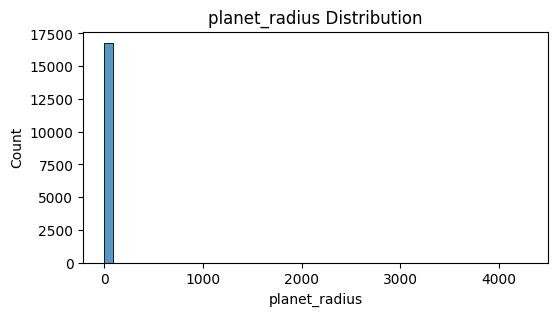

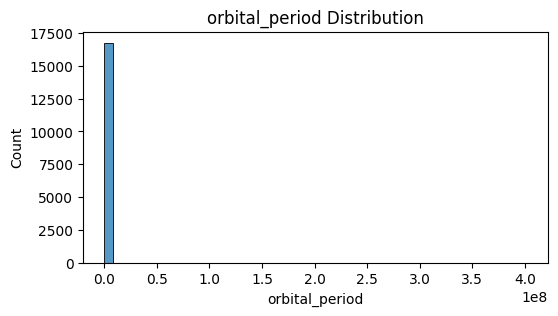

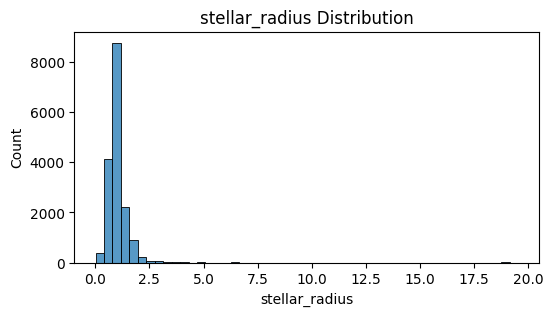

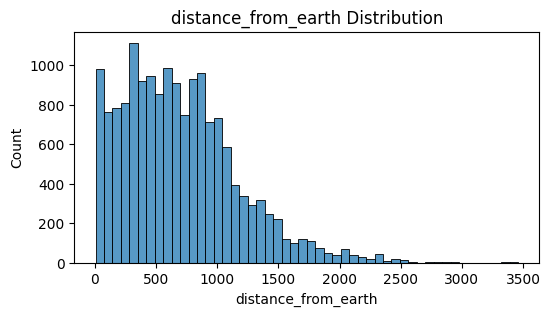

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['planet_radius','orbital_period','equilibrium_temperature',
            'stellar_mass','stellar_radius','distance_from_earth']

for col in features:
    plt.figure(figsize=(6,3))
    sns.histplot(df_clean[col].dropna(), bins=50)
    plt.title(f'{col} Distribution')
    plt.show()


In [ ]:
import plotly.express as px

fig = px.scatter_3d(
    df_clean,
    x='orbital_period',
    y='planet_radius',
    z='equilibrium_temperature',
    color='habitability_score',   # continuous gradient
    size='habitability_score',    # larger size = more habitable
    hover_data=['planet_name','stellar_mass','stellar_radius','distance_from_earth'],
    hover_name='planet_name',
    title='ExoAI 3D Habitability Visualization',
    color_continuous_scale='Viridis'
)
fig.show()


In [ ]:
top10 = df_clean.sort_values(by='habitability_score', ascending=False).head(10)

print("🌟 Top 10 Most Habitable Exoplanets 🌟")
display(top10[['planet_name','planet_radius','orbital_period','equilibrium_temperature',
               'stellar_mass','stellar_radius','distance_from_earth','habitability_score']])


🌟 Top 10 Most Habitable Exoplanets 🌟


planet_name  planet_radius  orbital_period  equilibrium_temperature  \
27023   Kepler-438 b       0.980000       35.233180                    273.0   
27015   Kepler-438 b       0.980000       35.233180                    273.0   
27019   Kepler-438 b       0.980000       35.233180                    273.0   
37113      TOI-700 e       0.949186       27.809690                    272.9   
13941  Kepler-1512 b       0.800000       20.359719                    276.0   
37110      TOI-700 d       1.144000       37.424750                    268.8   
27021   Kepler-438 b       0.970000       35.233069                    288.0   
35011     LP 890-9 c       1.367000        8.457463                    272.0   
26145   Kepler-395 c       1.250000       34.989447                    264.0   
26147   Kepler-395 c       1.250000       34.989447                    264.0   

       stellar_mass  stellar_radius  distance_from_earth  habitability_score  
27023         0.479        0.463000                  NaN               98.00  
27015         0.479        0.463000                  NaN               98.00  
27019         0.479        0.463000                  NaN               98.00  
37113           NaN        0.419457              31.1265               96.91  
13941         0.346        0.344000                  NaN               92.67  
37110         0.415        0.424000              31.1265               91.07  
27021         0.554        0.524000                  NaN               90.33  
35011         0.118        0.155600              32.4298               85.77  
26145         0.413        0.400000             421.3820               84.33  
26147         0.413        0.400000             421.3820               84.33

In [ ]:
fig_top10 = px.scatter_3d(
    df_clean,
    x='orbital_period',
    y='planet_radius',
    z='equilibrium_temperature',
    color='habitability_score',  # continuous gradient for all planets
    size='habitability_score',
    hover_data=['planet_name','stellar_mass','stellar_radius','distance_from_earth'],
    hover_name='planet_name',
    title='ExoAI 3D Habitability Visualization (Top 10 Highlighted)',
    color_continuous_scale='Viridis'
)

# Highlight Top 10 planets by adding a second trace
fig_top10.add_trace(
    px.scatter_3d(
        top10,
        x='orbital_period',
        y='planet_radius',
        z='equilibrium_temperature',
        size='habitability_score',
        hover_name='planet_name',
        color_discrete_sequence=['gold']
    ).data[0]
)

# Make the top 10 markers larger
fig_top10.data[-1].marker.size = fig_top10.data[-1].marker.size * 1.5

fig_top10.show()
